In [1]:
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "7"
torch.cuda.device_count()

1

In [2]:
from transformer_lens import HookedTransformer
from sae_lens import SAE
import torch
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

device = "cuda" if torch.cuda.is_available() else "cpu"

# get model
model = HookedTransformer.from_pretrained("google/gemma-2-2b", device = device)

layer = 15

# get the SAE for this layer
sae, cfg_dict, _ = SAE.from_pretrained(
    release = "gemma-scope-2b-pt-att-canonical",
    sae_id = f"layer_{layer}/width_16k/canonical",
    device = device
)

# get hook point
hook_point = sae.cfg.hook_name
print(hook_point)

/proj/inductive-bias.shadow/abakalov.anaconda/envs/sae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:44<00:00, 14.97s/it]


Loaded pretrained model google/gemma-2-2b into HookedTransformer
blocks.15.attn.hook_z


In [ ]:
from utils.get_steering_vector import get_steering_vectors_lr_and_mean_diff
from utils.dataset import get_tokenized_arc_easy_for_probing

res_layers_to_invade = [9, 10, 11, 13, 15]

tokenized_dataset = get_tokenized_arc_easy_for_probing(model=model, sae_context_size=sae.cfg.context_size,
                                                       dataset_split="train", batch_size=8, select_items=1500)
Xs_difference_res, lrs_res, hook_names_res = get_steering_vectors_lr_and_mean_diff(model=model, layers_to_invade=res_layers_to_invade,
                                                                       device="cuda",
                                                                       tokenized_dataset=tokenized_dataset, batch_size=8, type_of_activation="res")

In [ ]:
tokenized_dataset = get_tokenized_arc_easy_for_probing(model=model, sae_context_size=sae.cfg.context_size,
                                                       dataset_split="train", batch_size=8, select_items=1500)

In [3]:
from utils.get_steering_vector import get_steering_vectors_lr_and_mean_diff
from utils.dataset import get_tokenized_arc_easy_for_probing

res_layers_to_invade = [9, 10, 11, 13, 15]

tokenized_dataset = get_tokenized_arc_easy_for_probing(model=model, sae_context_size=sae.cfg.context_size,
                                                       dataset_split="train", batch_size=8, select_items=1500)
Xs_difference_res, lrs_res, hook_names_res = get_steering_vectors_lr_and_mean_diff(model=model, layers_to_invade=res_layers_to_invade,
                                                                       device="cuda",
                                                                       tokenized_dataset=tokenized_dataset, batch_size=8, type_of_activation="res")

Filter: 100%|██████████| 1500/1500 [00:00<00:00, 11315.65 examples/s]


1500 777


100%|██████████| 5/5 [07:34<00:00, 90.82s/it]


In [4]:
from utils.steering import get_arc_easy_accuracy_with_steering_multiple_hooks
import numpy as np

evaluated = {}
for activation_vector, layer, hook_point in zip(Xs_difference_res, res_layers_to_invade, hook_names_res):
    sae, cfg_dict, _ = SAE.from_pretrained(
        release = "gemma-scope-2b-pt-res-canonical",
        sae_id = f"layer_{layer}/width_16k/canonical",
        device = device
    )
    features = np.argsort(-activation_vector)
    coefs = -np.sort(-activation_vector)
    steering_vector = sum([sae.W_dec[feature] * coef for feature, coef in zip(features, coefs)])

    steering_strengths = [1.]
    res = get_arc_easy_accuracy_with_steering_multiple_hooks(model=model, hook_points=[hook_point], sae_context_size=1024,
                batch_size=8, dataset_split="validation", steering_vectors=[steering_vector],
                steering_strengths=steering_strengths)
    print(layer, res)
    evaluated[layer] = res
evaluated

27it [00:19,  1.34it/s]

72it [00:51,  1.41it/s]


9 (0.7, 2.168395194672702)


72it [00:49,  1.44it/s]


10 (0.6964912280701754, 2.204466500198632)


72it [00:49,  1.45it/s]


11 (0.6964912280701754, 2.202419746967784)


72it [00:52,  1.38it/s]


13 (0.7017543859649122, 2.2909758024048386)


72it [01:18,  1.10s/it]

15 (0.6929824561403509, 2.238745713652226)


{9: (0.7, 2.168395194672702),
 10: (0.6964912280701754, 2.204466500198632),
 11: (0.6964912280701754, 2.202419746967784),
 13: (0.7017543859649122, 2.2909758024048386),
 15: (0.6929824561403509, 2.238745713652226)}

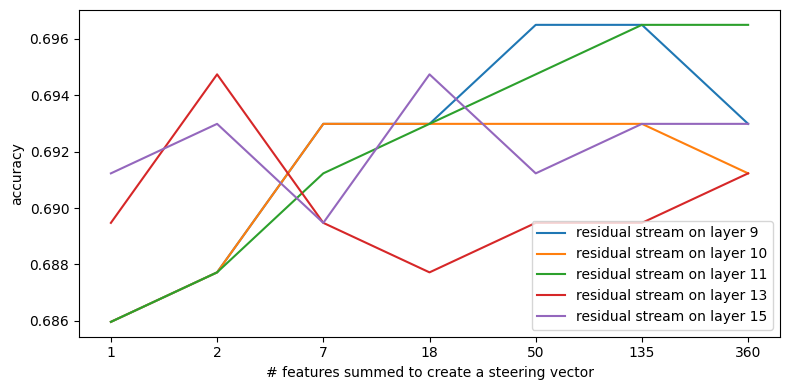

In [7]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1)
fig.set_size_inches((8, 4))
for layer in res_layers_to_invade:
    axs.plot([e[0] for e in evaluated[layer]], label=f"residual stream on layer {layer}")
axs.legend()
axs.set_xlabel("# features summed to create a steering vector")
axs.set_ylabel("accuracy")
labels = np.logspace(0, np.log10((Xs_difference_res[0] != 0).sum()), 10, base=10., dtype=int)[:7].tolist()

axs.set_xticks(np.arange(len(labels)), labels=labels)
fig.tight_layout()
plt.savefig("acc_by_num_of_features_on_different_layers.png")

In [65]:
from torch.nn.functional import cosine_similarity
import numpy as np

# num_vectors_arr = [0, 1, 2, 7, 18, 50]

res_layers_to_invade = [9, 10, 11, 13, 15]

num_vectors = 10

cosine_similarities = np.zeros((num_vectors, num_vectors))
for activation_vector, layer in zip(Xs_difference_res, res_layers_to_invade):
    if layer != 9:
        continue
    sae, cfg_dict, _ = SAE.from_pretrained(
            release = "gemma-scope-2b-pt-res-canonical",
            sae_id = f"layer_{layer}/width_16k/canonical",
            device = device
        )
    features = np.argsort(-np.abs(activation_vector))[:num_vectors]
    coefs = activation_vector[features]
    for activation_vector2, layer2 in zip(Xs_difference_res, res_layers_to_invade):
        if layer2 != 15:
            continue
        sae2, cfg_dict2, _ = SAE.from_pretrained(
            release = "gemma-scope-2b-pt-res-canonical",
            sae_id = f"layer_{layer2}/width_16k/canonical",
            device = device
        )
        features2 = np.argsort(-np.abs(activation_vector2))[:num_vectors]
        coefs2 = activation_vector2[features2]
        for i, f1 in enumerate(features):
            for j, f2 in enumerate(features2):
                vect1 = sae.W_dec[f1] * activation_vector[f1]
                vect2 = sae2.W_dec[f2] * activation_vector2[f2]
                cosine_similarities[i, j] = cosine_similarity(vect1, vect2, dim=0)
        break
    break

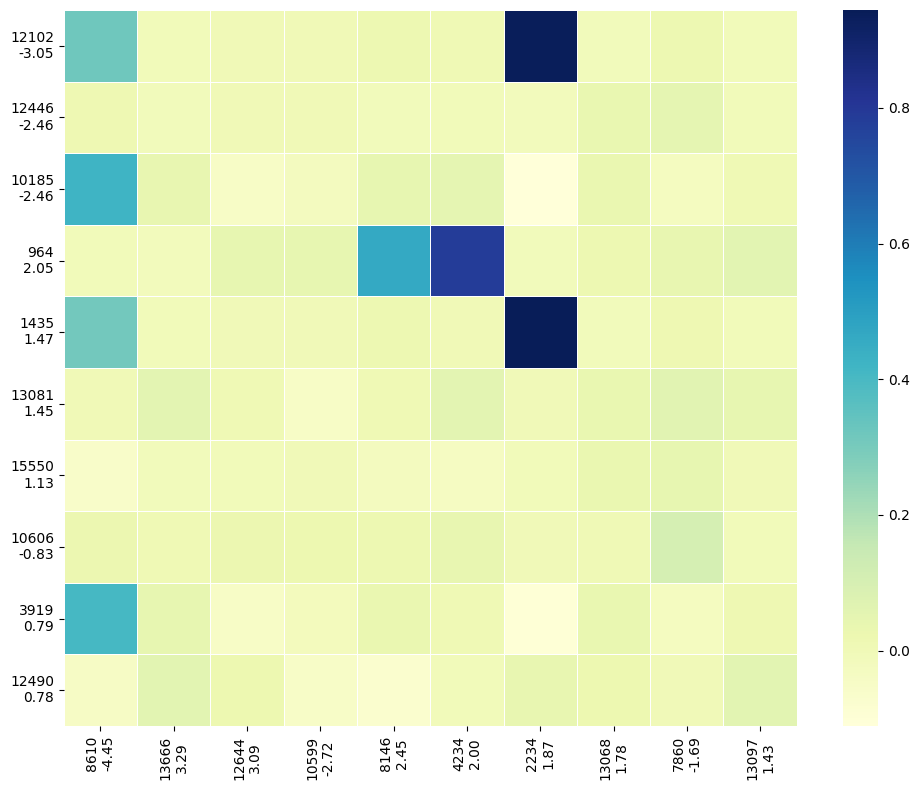

In [66]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

ax = sns.heatmap(cosine_similarities, linewidth=0.5, cmap="YlGnBu", yticklabels=[f"{feature}\n{coef:.2f}"for feature, coef in zip(features, coefs)],
                 xticklabels=[f"{feature}\n{coef:.2f}"for feature, coef in zip(features2, coefs2)])
ax.figure.set_size_inches((10, 8))
ax.figure.tight_layout()
plt.savefig("cosine_similarities_l_9_15.png")

In [84]:
from utils.steering import get_arc_easy_accuracy_with_steering_multiple_hooks
import numpy as np

layer = 9
activation_vector = Xs_difference_res[0]

sae, cfg_dict, _ = SAE.from_pretrained(
        release = "gemma-scope-2b-pt-res-canonical",
        sae_id = f"layer_{layer}/width_16k/canonical",
        device = device
    )

steering_vector = sum([sae.W_dec[feature] * activation_vector[feature] for feature in activation_vector.nonzero()[0]])

steering_strengths = [0.]
res = get_arc_easy_accuracy_with_steering_multiple_hooks(model=model, hook_points=[hook_names_res[0]], sae_context_size=1024,
            batch_size=8, dataset_split="validation", steering_vectors=[steering_vector],
            steering_strengths=steering_strengths)
res

72it [01:20,  1.12s/it]


(0.6894736842105263, 2.13550997365985)

In [83]:
from utils.steering import get_arc_easy_accuracy_with_steering_multiple_hooks
import numpy as np

layer = 9
activation_vector = Xs_difference_res[0]

sae, cfg_dict, _ = SAE.from_pretrained(
        release = "gemma-scope-2b-pt-res-canonical",
        sae_id = f"layer_{layer}/width_16k/canonical",
        device = device
    )

steering_vector = sum([sae.W_dec[feature] * activation_vector[feature] for feature in activation_vector.nonzero()[0]])

steering_strengths = [1.]
res = get_arc_easy_accuracy_with_steering_multiple_hooks(model=model, hook_points=[hook_names_res[0]], sae_context_size=1024,
            batch_size=8, dataset_split="validation", steering_vectors=[steering_vector],
            steering_strengths=steering_strengths)
res

72it [01:23,  1.16s/it]


(0.6982456140350877, 2.1613502745042767)

In [79]:
from utils.steering import get_arc_easy_accuracy_with_steering_multiple_hooks
import numpy as np

layer = 9
steering_vectors = []

for activation_vector, other_layer in zip(Xs_difference_res, res_layers_to_invade):
    sae, cfg_dict, _ = SAE.from_pretrained(
            release = "gemma-scope-2b-pt-res-canonical",
            sae_id = f"layer_{other_layer}/width_16k/canonical",
            device = device
        )
    steering_vector = sum([sae.W_dec[feature] * activation_vector[feature] for feature in activation_vector.nonzero()[0]])
    steering_vectors.append(steering_vector)

steering_vector = sum(steering_vectors)

steering_strengths = [1.]
res = get_arc_easy_accuracy_with_steering_multiple_hooks(model=model, hook_points=[hook_names_res[0]], sae_context_size=1024,
            batch_size=8, dataset_split="validation", steering_vectors=[steering_vector],
            steering_strengths=steering_strengths)
res

72it [01:24,  1.17s/it]


(0.6754385964912281, 1.61774717381126)

In [10]:
from utils.steering import get_arc_easy_accuracy_with_steering_multiple_hooks
from torch.nn.functional import cosine_similarity

import numpy as np

layer = 9
vectors_9 = []
activation_vector = Xs_difference_res[0]
sae, cfg_dict, _ = SAE.from_pretrained(
        release = "gemma-scope-2b-pt-res-canonical",
        sae_id = f"layer_{layer}/width_16k/canonical",
        device = device
    )

all_saes = {}
for other_layer in res_layers_to_invade:
    other_sae, _, _ = SAE.from_pretrained(
                release = "gemma-scope-2b-pt-res-canonical",
                sae_id = f"layer_{other_layer}/width_16k/canonical",
                device = device
            )
    all_saes[other_layer] = other_sae
    
for feature in activation_vector.nonzero()[0]:
    vectors_9.append(sae.W_dec[feature] * activation_vector[feature])
for i, feature in enumerate(activation_vector.nonzero()[0]):
    vect1 = sae.W_dec[feature] * activation_vector[feature]
    for other_activation_vector, other_layer in zip(Xs_difference_res, res_layers_to_invade):
        if other_layer == layer:
            continue
        for other_feature in other_activation_vector.nonzero()[0]:
            vect2 = all_saes[other_layer].W_dec[other_feature] * other_activation_vector[other_feature]
            cosine_sim = cosine_similarity(vect1, vect2, dim=0)
            if cosine_sim < -0.7:
                print("aa")
                vectors_9[i] = torch.zeros_like(vectors_9[i])
            break
        if (vectors_9[i] == 0).all():
            break

steering_vector = sum(vectors_9)

steering_strengths = [1.]
res = get_arc_easy_accuracy_with_steering_multiple_hooks(model=model, hook_points=[hook_names_res[0]], sae_context_size=1024,
            batch_size=8, dataset_split="validation", steering_vectors=[steering_vector],
            steering_strengths=steering_strengths)
res

72it [02:20,  1.95s/it]


(0.6982456140350877, 2.1613502745042767)

In [9]:
sum([(v == 0).all() for v in vectors_9])

tensor(0, device='cuda:0')

In [87]:
torch.cuda.empty_cache()